# Coordinates

This file contains the processing of coordinates data in the yelp restaurant dataset.

**Goal:** Provide a coordinates_processing function, which can be used in main.ipynb.

## 1. Get the coordinates dataset

The coordinates dataset only contains price, rating, review_count, name, id, coordinates (latitude, longitude) columns. Extraction of this dataset is shown in main.ipynb.

In [221]:
import pickle
import requests
import json
import os
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools

In [2]:
origin_data_file = '../Dataset/coordinates_data'

with open(origin_data_file, 'rb') as inFile:
    origin_data = pickle.load(inFile)

display(origin_data.head())
print("origin_data.shape: {0}".format(origin_data.shape))

,id,name,latitude,longitude,rating,review_count,price
0,bwCj2AcoOroZfCTxb6rCcg,A Better Burger,36.689639,-83.108766,3.5,6,2
1,S9S9kFJSkmfpbjFForCWLQ,El Castillo,36.726337,-83.099858,4.0,2,1
2,np8uV1xll22Yr-Q-B-ImkA,Rooster's Pub,36.758436,-83.027057,4.5,4,1
3,HGY1ojoLu07P_ky2LeRguQ,Redstone Restaurant,36.689259,-82.753040,4.5,3,1
4,J5XS3VmxnLKhNlpiwDJ-3A,Little Mexico,36.859367,-82.756744,4.0,5,1


origin_data.shape: (5119, 7)


## 2. Get census tract data
Extract cencus tract information in Virginia for further processing.

**Census tract geographic data**: The census tract data is downloaded from [2010 Census Gazetteer Files](https://www.census.gov/geo/maps-data/data/gazetteer2010.html).

In [33]:
tract_file = "../dataset/Gaz_tracts_national.txt"

with open(tract_file, 'r') as infile:
    tract_df = pd.read_csv(infile, sep = "\t", dtype={'GEOID':object})

# Drop not in VA
tract_df = tract_df.loc[tract_df['USPS'] == 'VA'].reset_index(drop=True)

tract_df.columns = tract_df.columns.str.lower()

In [34]:
tract_df.head()

,usps,geoid,pop10,hu10,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong
0,VA,51001090100,2941,4517,18529985,37927447,7.154,14.644,37.945138,-75.362044
1,VA,51001090200,6156,4259,187805809,36543634,72.512,14.110,37.953865,-75.503313
2,VA,51001090300,2335,1221,128431098,61781712,49.588,23.854,37.887621,-75.662907
3,VA,51001090400,6234,2687,193719276,35803197,74.795,13.824,37.752376,-75.598061
4,VA,51001090500,2849,1361,65940306,39496129,25.460,15.250,37.814134,-75.696946


**Cencus tract data**: including sex by age, household income, age by language, and place of birth. These data is downloaded from [Census Reporter](https://censusreporter.org/profiles/04000US51-virginia/).

- **Sex by age data processing**

In [35]:
sex_by_age_path = '../dataset/sex_by_age/'

# Process data.csv
with open(os.path.join(sex_by_age_path, 'data.csv'), 'r') as infile:
    sex_by_age_df = pd.read_csv(infile)

# Drop US and Virginia rows
sex_by_age_df.drop(index=[0, 1], inplace=True)
sex_by_age_df.reset_index(inplace=True, drop=True)

# Get column names from metadata.json
with open(os.path.join(sex_by_age_path, 'metadata.json'), 'r') as infile:
    metadata = json.load(infile)

isMaleNow = False
change_cols = {}
for col in metadata['tables']['B01001']['columns'].items():
    if(col[1]['name'] == 'Total:'):
        change_cols[col[0]] = 'total_population'
    elif(col[1]['name'] == 'Male:'):
        change_cols[col[0]] = 'total_male_population'
        isMaleNow = True
    elif(col[1]['name'] == 'Female:'):
        change_cols[col[0]] = 'total_female_population'
        isMaleNow = False
    elif(isMaleNow):
        change_cols[col[0]] = 'male_'+col[1]['name'].lower().replace(' ', '_')
    else:
        change_cols[col[0]] = 'female_'+col[1]['name'].lower().replace(' ', '_')
        
sex_by_age_df.rename(columns=change_cols, inplace=True)

# Drop error and name columns
error_cols = ['name']
for col in sex_by_age_df.columns:
    if(col[0] == 'B'):
        error_cols.append(col)

sex_by_age_df.drop(columns=error_cols, inplace=True)

# Alter geoid so that it can merge with tract data
for i, row in sex_by_age_df.iterrows():
    sex_by_age_df.loc[i, 'geoid'] = row['geoid'][7:]

In [36]:
sex_by_age_df.head(2)

,geoid,total_population,total_male_population,male_under_5_years,male_5_to_9_years,male_10_to_14_years,male_15_to_17_years,male_18_and_19_years,male_20_years,male_21_years,...,female_50_to_54_years,female_55_to_59_years,female_60_and_61_years,female_62_to_64_years,female_65_and_66_years,female_67_to_69_years,female_70_to_74_years,female_75_to_79_years,female_80_to_84_years,female_85_years_and_over
0,51001090100,2919,1354,78,67,96,7,25,9,0,...,129,143,82,84,70,86,83,103,56,38
1,51001090200,6407,3157,251,195,111,60,0,0,8,...,250,195,69,215,210,53,200,88,48,100


In [37]:
# Put sex_by_age data into census tract dataframe
tract_df = pd.merge(tract_df, sex_by_age_df, on='geoid', how='left')

- **Household income data processing**

In [38]:
household_path = '../dataset/household_income/'

# Process data.csv
with open(os.path.join(household_path, 'data.csv'), 'r') as infile:
    household_df = pd.read_csv(infile)

# Drop US and Virginia rows
household_df.drop(index=[0, 1], inplace=True)
household_df.reset_index(inplace=True, drop=True)

# Get column names from metadata.json
with open(os.path.join(household_path, 'metadata.json'), 'r') as infile:
    metadata = json.load(infile)

change_cols = {}
for col in metadata['tables']['B19001']['columns'].items():
    if(col[1]['name'] == 'Total:'):
        change_cols[col[0]] = 'total_household_income'
    else:
        change_cols[col[0]] = 'house_'+col[1]['name'].lower().replace(' ', '_').replace('$', '')
        
household_df.rename(columns=change_cols, inplace=True)

# Drop error and name columns
error_cols = ['name']
for col in household_df.columns:
    if(col[0] == 'B'):
        error_cols.append(col)

household_df.drop(columns=error_cols, inplace=True)

# Alter geoid so that it can merge with tract data
for i, row in household_df.iterrows():
    household_df.loc[i, 'geoid'] = row['geoid'][7:]

In [39]:
household_df.head(2)

,geoid,total_household_income,"house_less_than_10,000","house_10,000_to_14,999","house_15,000_to_19,999","house_20,000_to_24,999","house_25,000_to_29,999","house_30,000_to_34,999","house_35,000_to_39,999","house_40,000_to_44,999","house_45,000_to_49,999","house_50,000_to_59,999","house_60,000_to_74,999","house_75,000_to_99,999","house_100,000_to_124,999","house_125,000_to_149,999","house_150,000_to_199,999","house_200,000_or_more"
0,51001090100,1382,120,41,77,79,104,92,65,85,74,108,172,145,77,64,23,56
1,51001090200,2638,177,115,216,279,198,151,223,68,234,206,275,266,122,18,15,75


In [40]:
# Put household_income data into census tract dataframe
tract_df = pd.merge(tract_df, household_df, on='geoid', how='left')

- **Age by language data processing**

In [41]:
language_path = '../dataset/age_by_language/'

# Process data.csv
with open(os.path.join(language_path, 'data.csv'), 'r') as infile:
    language_df = pd.read_csv(infile)

# Drop US and Virginia rows
language_df.drop(index=[0, 1], inplace=True)
language_df.reset_index(inplace=True, drop=True)

# Get column names from metadata.json
with open(os.path.join(language_path, 'metadata.json'), 'r') as infile:
    metadata = json.load(infile)

prefix = ""
change_cols = {}
for col in metadata['tables']['B16007']['columns'].items():
    if(col[1]['name'] == 'Total:'):
        change_cols[col[0]] = 'total'
    elif(col[1]['name'] == '5 to 17 years:'):
        change_cols[col[0]] = 'total_5_to_17'
        prefix = '5_to_17_'
    elif(col[1]['name'] == '18 to 64 years:'):
        change_cols[col[0]] = 'total_18_to_64'
        prefix = '18_to_64_'
    else:
        change_cols[col[0]] = prefix+col[1]['name'].lower().replace(' ', '_')
        
language_df.rename(columns=change_cols, inplace=True)

# Drop error, name and total columns
error_cols = ['name', 'total']
for col in language_df.columns:
    if(col[0] == 'B'):
        error_cols.append(col)

language_df.drop(columns=error_cols, inplace=True)

# Alter geoid so that it can merge with tract data
for i, row in language_df.iterrows():
    language_df.loc[i, 'geoid'] = row['geoid'][7:]

In [42]:
language_df.head(2)

,geoid,total_5_to_17,5_to_17_speak_only_english,5_to_17_speak_spanish,5_to_17_speak_other_indo-european_languages,5_to_17_speak_asian_and_pacific_island_languages,5_to_17_speak_other_languages,total_18_to_64,18_to_64_speak_only_english,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages,18_to_64_65_years_and_over:,18_to_64_speak_only_english,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages
0,51001090100,298,298,0,0,0,0,1656,1595,37,24,0,0,818,769,0,49,0,0
1,51001090200,869,762,61,46,0,0,3681,3421,237,23,0,0,1271,1247,24,0,0,0


In [43]:
# Put age_by_language data into census tract dataframe
tract_df = pd.merge(tract_df, language_df, on='geoid', how='left')

- **Place of birth data processing**

In [186]:
birth_path = '../dataset/place_of_birth/'

# Process data.csv
with open(os.path.join(birth_path, 'data.csv'), 'r') as infile:
    birth_df = pd.read_csv(infile)

# Drop US and Virginia rows
birth_df.drop(index=[0, 1], inplace=True)
birth_df.reset_index(inplace=True, drop=True)

# Get column names from metadata.json
with open(os.path.join(birth_path, 'metadata.json'), 'r') as infile:
    metadata = json.load(infile)

prefix = ""
change_cols = {}
for col in metadata['tables']['B05006']['columns'].items():
    if(col[1]['name'] == 'Total:'):
        change_cols[col[0]] = 'total'
    elif(col[1]['name'][-1] == ':'):
        change_cols[col[0]] = prefix+col[1]['name'][:-1].lower().replace(' ', '_')
        
birth_df.rename(columns=change_cols, inplace=True)

# Drop error, name and total columns
error_cols = ['name', 'total']
for col in birth_df.columns:
    if(col[0] == 'B'):
        error_cols.append(col)

birth_df.drop(columns=error_cols, inplace=True)

# Alter geoid so that it can merge with tract data
for i, row in birth_df.iterrows():
    birth_df.loc[i, 'geoid'] = row['geoid'][7:]

In [188]:
birth_df.head(2)

,geoid,europe,northern_europe,united_kingdom_(inc._crown_dependencies),western_europe,southern_europe,eastern_europe,asia,eastern_asia,china,...,southern_africa,western_africa,oceania,australia_and_new_zealand_subregion,americas,latin_america,caribbean,central_america,south_america,northern_america
0,51001090100,39,9,0,8,22,0,24,0,0,...,0,0,0,0,0,0,0,0,0,0
1,51001090200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,149,149,8,141,0,0


In [189]:
# Put place_of_birth data into census tract dataframe
tract_df = pd.merge(tract_df, birth_df, on='geoid', how='left')

In [190]:
# Final tract_df
tract_df.head()

,usps,geoid,pop10,hu10,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong,...,southern_africa,western_africa,oceania,australia_and_new_zealand_subregion,americas,latin_america,caribbean,central_america,south_america,northern_america
0,VA,51001090100,2941,4517,18529985,37927447,7.154,14.644,37.945138,-75.362044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,VA,51001090200,6156,4259,187805809,36543634,72.512,14.110,37.953865,-75.503313,...,0.0,0.0,0.0,0.0,149.0,149.0,8.0,141.0,0.0,0.0
2,VA,51001090300,2335,1221,128431098,61781712,49.588,23.854,37.887621,-75.662907,...,0.0,0.0,0.0,0.0,64.0,64.0,7.0,57.0,0.0,0.0
3,VA,51001090400,6234,2687,193719276,35803197,74.795,13.824,37.752376,-75.598061,...,0.0,0.0,0.0,0.0,1084.0,1083.0,241.0,842.0,0.0,1.0
4,VA,51001090500,2849,1361,65940306,39496129,25.460,15.250,37.814134,-75.696946,...,0.0,0.0,0.0,0.0,284.0,275.0,99.0,176.0,0.0,9.0


In [191]:
tract_df.columns

Index(['usps', 'geoid', 'pop10', 'hu10', 'aland', 'awater', 'aland_sqmi',
       'awater_sqmi', 'intptlat', 'intptlong',
       ...
       'southern_africa', 'western_africa', 'oceania',
       'australia_and_new_zealand_subregion', 'americas', 'latin_america',
       'caribbean', 'central_america', 'south_america', 'northern_america'],
      dtype='object', length=120)

## 3. Add new features to coordinates dataset
This section includes:
1. For each business, decide which census tract it belongs to: Call [FCC Area API](https://geo.fcc.gov/api/census/#!/area/get_area) to get geoid of each business.
2. Add corresponding census tract features.

In [16]:
url = 'https://geo.fcc.gov/api/census/area'
def get_geoid(lat, lon):
    """For coordinate (lat, lon), decide which census tract it belongs to.
    """
    url_params = {
        'lat': lat,
        'lon': lon,
        'format': 'json'
    }
    
    response = requests.request('GET', url, params=url_params)
    result = response.json()['results']
    if(result == []):
        geoid = get_geoid(lon, lat)
    else:
        geoid = result[0]['block_fips'][:-4]
    return geoid

In [17]:
geo_biz_data = pd.DataFrame(origin_data)
geo_biz_data = geo_biz_data.assign(geoid=np.zeros(origin_data.shape[0]))

In [18]:
for i, row in origin_data.iterrows():
    if(i % 300 == 0):
        print("Calculate row {0}...".format(i))
    lat, lon = row[['latitude', 'longitude']]
    geo_biz_data.loc[i, 'geoid'] = get_geoid(lat, lon)    

Calculate row 0...
Calculate row 300...
Calculate row 600...
Calculate row 900...
Calculate row 1200...
Calculate row 1500...
Calculate row 1800...
Calculate row 2100...
Calculate row 2400...
Calculate row 2700...
Calculate row 3000...
Calculate row 3300...
Calculate row 3600...
Calculate row 3900...
Calculate row 4200...
Calculate row 4500...
Calculate row 4800...
Calculate row 5100...


In [203]:
cols_to_use = tract_df.columns.difference(geo_biz_data.columns)
cols_to_use = cols_to_use.tolist()
cols_to_use.append('geoid')

In [204]:
geo_biz_data = pd.merge(geo_biz_data, tract_df[cols_to_use], on='geoid')

In [205]:
geo_biz_data.head()

,id,name,latitude,longitude,rating,review_count,price,geoid,usps,pop10,...,oceania,south_america,south_central_asia,south_eastern_asia,southern_africa,southern_europe,united_kingdom_(inc._crown_dependencies),western_africa,western_asia,western_europe
0,bwCj2AcoOroZfCTxb6rCcg,A Better Burger,36.689639,-83.108766,3.5,6,2,51105950500,VA,4914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S9S9kFJSkmfpbjFForCWLQ,El Castillo,36.726337,-83.099858,4.0,2,1,51105950500,VA,4914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,np8uV1xll22Yr-Q-B-ImkA,Rooster's Pub,36.758436,-83.027057,4.5,4,1,51105950300,VA,5532,...,0.0,41.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HGY1ojoLu07P_ky2LeRguQ,Redstone Restaurant,36.689259,-82.753040,4.5,3,1,51169030300,VA,3674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,J5XS3VmxnLKhNlpiwDJ-3A,Little Mexico,36.859367,-82.756744,4.0,5,1,51195931200,VA,6649,...,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,7.0


**Data preprocessing**

In [206]:
# NaN data
geo_biz_data = geo_biz_data.fillna(0)

**Save geo_biz_data and tract_df**: Avoid repeatedly calling API.

In [207]:
save_path = '../Dataset/geo_biz_data'

In [208]:
with open(save_path, 'wb') as outfile:
    pickle.dump([tract_df, geo_biz_data], outfile)

In [209]:
with open(save_path, 'rb') as infile:
    tract_df, geo_biz_data = pickle.load(infile)

## 4. Data Analysis

**Correlation**

In [210]:
corr_matrix = geo_biz_data.corr()

corr_price = corr_matrix["price"].sort_values(ascending=False)

print(corr_price.head(20))
print("...")
print(corr_price.tail(20))

price                                                1.000000
avg_price                                            0.566762
review_count                                         0.252846
intptlong                                            0.176094
house_200,000_or_more                                0.168795
18_to_64_speak_other_indo-european_languages         0.144695
europe                                               0.142355
house_150,000_to_199,999                             0.138635
asia                                                 0.136522
longitude                                            0.125701
18_to_64_speak_asian_and_pacific_island_languages    0.121818
18_to_64_speak_other_indo-european_languages         0.118117
18_to_64_speak_asian_and_pacific_island_languages    0.115547
eastern_asia                                         0.114715
18_to_64_speak_other_languages                       0.112848
eastern_europe                                       0.112422
south_ce

**Calculate avearge restaurant price in census tracts**

In [211]:
tract_df.head()

,usps,geoid,pop10,hu10,aland,awater,aland_sqmi,awater_sqmi,intptlat,intptlong,...,southern_africa,western_africa,oceania,australia_and_new_zealand_subregion,americas,latin_america,caribbean,central_america,south_america,northern_america
0,VA,51001090100,2941,4517,18529985,37927447,7.154,14.644,37.945138,-75.362044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,VA,51001090200,6156,4259,187805809,36543634,72.512,14.110,37.953865,-75.503313,...,0.0,0.0,0.0,0.0,149.0,149.0,8.0,141.0,0.0,0.0
2,VA,51001090300,2335,1221,128431098,61781712,49.588,23.854,37.887621,-75.662907,...,0.0,0.0,0.0,0.0,64.0,64.0,7.0,57.0,0.0,0.0
3,VA,51001090400,6234,2687,193719276,35803197,74.795,13.824,37.752376,-75.598061,...,0.0,0.0,0.0,0.0,1084.0,1083.0,241.0,842.0,0.0,1.0
4,VA,51001090500,2849,1361,65940306,39496129,25.460,15.250,37.814134,-75.696946,...,0.0,0.0,0.0,0.0,284.0,275.0,99.0,176.0,0.0,9.0


In [62]:
tract_price_df = pd.DataFrame(tract_df[['geoid', 'intptlat', 'intptlong']])
tract_price_df = tract_price_df.assign(avg_price=np.zeros(tract_price_df.shape[0]))
tract_price_df = tract_price_df.assign(num_restaurant=np.zeros(tract_price_df.shape[0]))

for i, row in geo_biz_data.iterrows():
    tract_idx = tract_df['geoid'].index[tract_df['geoid'] == row['geoid']][0]
    num = tract_price_df.loc[tract_idx, 'num_restaurant']
    avg = tract_price_df.loc[tract_idx, 'avg_price']
    if(num == 0):
        tract_price_df.loc[tract_idx, 'avg_price'] = row['price']
    else:
        tract_price_df.loc[tract_idx, 'avg_price'] = (avg*num + row['price'])/(num + 1)
    tract_price_df.loc[tract_idx, 'num_restaurant'] = num + 1

In [81]:
geo_biz_data = pd.merge(geo_biz_data, tract_price_df[['avg_price', 'num_restaurant', 'geoid']], on='geoid')

In [82]:
geo_biz_data

,id,name,latitude,longitude,rating,review_count,price,geoid,usps,pop10,...,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages,18_to_64_65_years_and_over:,18_to_64_speak_only_english,18_to_64_speak_spanish,18_to_64_speak_other_indo-european_languages,18_to_64_speak_asian_and_pacific_island_languages,18_to_64_speak_other_languages,avg_price,num_restaurant
0,bwCj2AcoOroZfCTxb6rCcg,A Better Burger,36.689639,-83.108766,3.5,6,2,51105950500,VA,4914,...,0.0,0.0,1074.0,1074.0,0.0,0.0,0.0,0.0,1.500000,2.0
1,S9S9kFJSkmfpbjFForCWLQ,El Castillo,36.726337,-83.099858,4.0,2,1,51105950500,VA,4914,...,0.0,0.0,1074.0,1074.0,0.0,0.0,0.0,0.0,1.500000,2.0
2,np8uV1xll22Yr-Q-B-ImkA,Rooster's Pub,36.758436,-83.027057,4.5,4,1,51105950300,VA,5532,...,20.0,40.0,979.0,976.0,3.0,0.0,0.0,0.0,1.000000,1.0
3,HGY1ojoLu07P_ky2LeRguQ,Redstone Restaurant,36.689259,-82.753040,4.5,3,1,51169030300,VA,3674,...,0.0,0.0,623.0,623.0,0.0,0.0,0.0,0.0,1.000000,1.0
4,J5XS3VmxnLKhNlpiwDJ-3A,Little Mexico,36.859367,-82.756744,4.0,5,1,51195931200,VA,6649,...,20.0,0.0,1045.0,1039.0,0.0,0.0,6.0,0.0,1.000000,3.0
5,M8Bj2aN_IQztq7DtU5Zzaw,Red Flower Chinese Restaurant,36.866594,-82.775797,3.0,9,1,51195931200,VA,6649,...,20.0,0.0,1045.0,1039.0,0.0,0.0,6.0,0.0,1.000000,3.0
6,ZYwY_8tNCWyj9GJX6pNTJA,Pizza King,36.869690,-82.776054,3.5,5,1,51195931200,VA,6649,...,20.0,0.0,1045.0,1039.0,0.0,0.0,6.0,0.0,1.000000,3.0
7,NHUXusyDjSDYBTeKnTYNbQ,Pizza Hut,36.762107,-83.015356,4.0,3,2,51105950100,VA,3438,...,8.0,42.0,446.0,446.0,0.0,0.0,0.0,0.0,2.000000,1.0
8,KQulbF1_byfZYrt6kHvySg,Gasthaus Edelweiss,36.621174,-82.568932,5.0,4,2,51169030600,VA,4037,...,22.0,0.0,994.0,984.0,6.0,4.0,0.0,0.0,1.500000,2.0
9,EepsrfoWQhupmOsDjHgM1Q,Handy Kitchen,36.616143,-82.567972,5.0,8,1,51169030600,VA,4037,...,22.0,0.0,994.0,984.0,6.0,4.0,0.0,0.0,1.500000,2.0


**Try t-SNE and PCA**

In [220]:
# Using t-SNE to visualize data
X = geo_biz_data.drop(columns=['id', 'name', 'usps', 'geoid', 'price']).values
y = geo_biz_data['price'].values
X_tsne = TSNE(n_components=2,random_state=33, verbose=1).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5116 samples in 0.037s...
[t-SNE] Computed neighbors for 5116 samples in 1.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5116
[t-SNE] Computed conditional probabilities for sample 2000 / 5116
[t-SNE] Computed conditional probabilities for sample 3000 / 5116
[t-SNE] Computed conditional probabilities for sample 4000 / 5116
[t-SNE] Computed conditional probabilities for sample 5000 / 5116
[t-SNE] Computed conditional probabilities for sample 5116 / 5116
[t-SNE] Mean sigma: 244.505600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.881847
[t-SNE] KL divergence after 1000 iterations: 0.178249


NameError: name 'PCA' is not defined

In [222]:
X_pca = PCA(n_components=2).fit_transform(X)

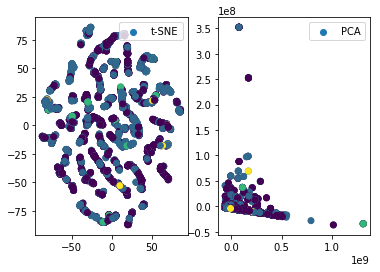

In [223]:
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y,label="t-SNE")
plt.legend()
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,label="PCA")
plt.legend()
plt.show()

## 5. Generate classifier

In [236]:
X = geo_biz_data.drop(columns=['id', 'name', 'usps', 'geoid', 'price', 'latitude', 'longitude']).values
y = geo_biz_data['price'].values

In [237]:
# Devide train/test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('{0} train + {1} test'.format(len(X_train), len(X_test)))

4092 train + 1024 test


In [238]:
# Feature scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [239]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Linear SVM:
Cross Val Avg. Score: 0.694048362177379
Accuracy Score in test set: 0.7001953125
Confusion matrix, without normalization
[[267 138   0   0]
 [137 450   0   0]
 [  2  29   0   0]
 [  0   1   0   0]]


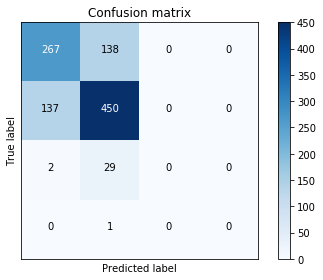

Decision Tree:
Cross Val Avg. Score: 0.6986923688929276
Accuracy Score in test set: 0.69921875
Confusion matrix, without normalization
[[272 133   0   0]
 [143 444   0   0]
 [  1  30   0   0]
 [  0   1   0   0]]


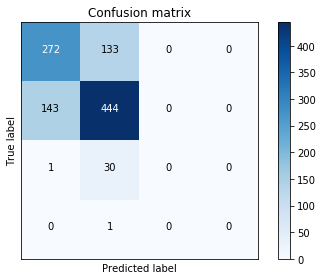

AdaBoost:
Cross Val Avg. Score: 0.6869579129471688
Accuracy Score in test set: 0.6767578125
Confusion matrix, without normalization
[[309  95   0   1]
 [202 381   4   0]
 [  1  27   3   0]
 [  0   0   1   0]]


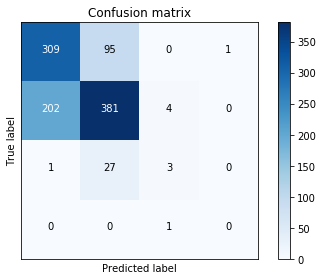

Voting:
Cross Val Avg. Score: 0.6996611101745371
Accuracy Score in test set: 0.701171875
Confusion matrix, without normalization
[[277 128   0   0]
 [146 441   0   0]
 [  1  30   0   0]
 [  0   1   0   0]]


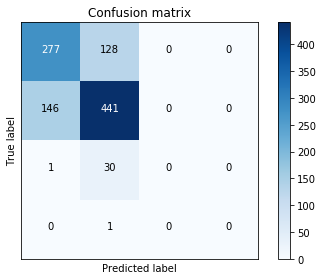

<Figure size 432x288 with 0 Axes>

In [240]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

h = .02  # step size in the mesh

names = ["Linear SVM", "Decision Tree", "AdaBoost", "Voting"]

classifiers = [
    SVC(kernel="linear", C=0.01, decision_function_shape='ovo'),
    DecisionTreeClassifier(max_depth=2),
    AdaBoostClassifier(n_estimators=20),
    VotingClassifier(estimators=[
        ('svc', SVC(kernel="linear", C=0.01)), 
        ('rbf_svc', SVC(gamma=1, C=0.1, decision_function_shape='ovo')),
        ('tree', DecisionTreeClassifier(max_depth=2)), 
        ('ada', AdaBoostClassifier(n_estimators=20))], voting='hard')
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    cross_scores = cross_val_score(clf, X_train, y_train, cv=5)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    score = clf.score(X_test, y_test)
    
    print("{0}:".format(name))
    print('Cross Val Avg. Score:',np.mean(cross_scores))
    print("Accuracy Score in test set: {0}".format(score))
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[])
    plt.show()

plt.tight_layout()
plt.show()

## * Generate dataset for Gephi

Now we are going to consider the relation between restaurants as a undirected network graph. Definition of this graph is listed as follows:

**Node:** Each node represents a business, which can be uniquely represented by its id.

**Edge:** Each edge $(u, v)$ represents that the business $u$ is a neighbor of $v$ $(u \neq v)$. Here, we define a parameter, neighbor_dist, as the maximum distance (kilometer) between two neighbors. If the distance of two businesses, $u$ and $v$, is less than neighbor_dist, then we will have edge $(u, v)$ and $(v, u)$.

To calculate the distance between two businesses on the earth, we here adopted the Haversine formula. The code is based on [Haversine formula in Python](https://stackoverflow.com/a/4913653/8163369) on StackOverFlow.

In [ ]:
neighbor_dist = 0.5 # The maximum distance (kilometer) between two neighbors

lats, lons = np.array(data['latitude']), np.array(data['longitude']) # latitude and longitude of businesses
num_samples = data.shape[0] # total number of businesses

edges = []

for i in range(0, num_samples):
    for j in range(i + 1, num_samples):
        dist = haversine(lons[i], lats[i], lons[j], lats[j])
        if(dist < neighbor_dist):
            edges.append([i, j, dist + 0.001])
            edges.append([j, i, dist + 0.001])

In [ ]:
len(edges)

**Output nodes and as .csv file:** for use of Gephi.

In [ ]:
# Generate edges and nodes dataframe as the requirement of Gephi
edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])

nodes_df = data.rename(columns={'id': 'label'})
nodes_df = nodes_df.assign(id=range(0, num_samples))

display(edges_df.head())
display(nodes_df.head())

In [ ]:
# Write dataframes into files
nodes_file = './Gephi/coordinates_nodes.csv'
edges_file = './Gephi/coordinates_edges.csv'

with open(nodes_file, 'w', encoding='utf-8') as outFile:
    nodes_df.to_csv(outFile, sep=',', encoding='utf-8', index=False)

with open(edges_file, 'w') as outFile:
    edges_df.to_csv(outFile, sep=',', encoding='utf-8', index=False)